



#Environment Setup


## Install

In [0]:
%%capture    
#%%capture disable cell output
!pip install mlflow
!pip install lime

## Import

In [0]:
from torchtext import datasets #https://pytorch.org/text/datasets.html
from torchtext import data
from torchtext.data import BucketIterator
from torchtext.vocab import GloVe

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
from itertools import cycle

import numpy as np

import mlflow
import mlflow.pyfunc
import pickle
import lime
from lime.lime_text import LimeTextExplainer

from google.colab import drive

# Import, split and pre-process data

In [0]:
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)

# make splits for data
train, test = datasets.TREC.splits(TEXT, LABEL)
# build the vocabulary
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train)
# make iterator for splits
train_iter, test_iter = data.BucketIterator.splits(
    (train, test), batch_size=3, device=0)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [0]:
set(train.label)

{'ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'}

In [0]:
train.fields

{'label': <torchtext.data.field.Field at 0x7f2d869b32e8>,
 'text': <torchtext.data.field.Field at 0x7f2d869b32b0>}

In [0]:
dir(TEXT)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'batch_first',
 'build_vocab',
 'dtype',
 'dtypes',
 'eos_token',
 'fix_length',
 'include_lengths',
 'init_token',
 'is_target',
 'lower',
 'numericalize',
 'pad',
 'pad_first',
 'pad_token',
 'postprocessing',
 'preprocess',
 'preprocessing',
 'process',
 'sequential',
 'stop_words',
 'tokenize',
 'truncate_first',
 'unk_token',
 'use_vocab',
 'vocab',
 'vocab_cls']

In [0]:
dir(TEXT.vocab)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'extend',
 'freqs',
 'itos',
 'load_vectors',
 'set_vectors',
 'stoi',
 'vectors']

In [0]:
vocab = TEXT.vocab
vocab

In [0]:
vocab.stoi['why']

47

In [0]:
vocab.vectors

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0833, -0.2090, -0.0436,  ..., -0.1775,  0.0558,  0.8013],
        ...,
        [-0.2082,  0.1944,  0.2650,  ...,  0.4414,  0.8425,  0.4868],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4210, -0.5008,  0.5342,  ...,  0.6741,  0.1884,  0.3817]])

# Label Encoding

In [0]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(list(train.label))
y_test = encoder.fit_transform(list(test.label))

X_train = [' '.join(question) for question in train.text]
X_test = [' '.join(question) for question in test.text]

In [0]:
print(X_train)

['how did serfdom develop in and then leave russia ?', 'what films featured the character popeye doyle ?', "how can i find a list of celebrities ' real names ?", 'what fowl grabs the spotlight after the chinese year of the monkey ?', 'what is the full form of .com ?', 'what contemptible scoundrel stole the cork from my lunch ?', "what team did baseball 's st. louis browns become ?", 'what is the oldest profession ?', 'what are liver enzymes ?', 'name the scar-faced bounty hunter of the old west .', 'when was ozzy osbourne born ?', 'why do heavier objects travel downhill faster ?', 'who was the pride of the yankees ?', 'who killed gandhi ?', 'what is considered the costliest disaster the insurance industry has ever faced ?', 'what sprawling u.s. state boasts the most airports ?', 'what did the only repealed amendment to the u.s. constitution deal with ?', 'how many jews were executed in concentration camps during wwii ?', "what is `` nine inch nails '' ?", 'what is an annotated bibliogr

In [0]:
type(y_test)

numpy.ndarray

In [0]:
y_test.shape

(500,)

In [0]:
y_train.shape

(5452,)

# Fit Model

In [0]:
text_clf = Pipeline([('vect', CountVectorizer()), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', SVC(probability=True)),])
y_score = text_clf.fit(X_train, y_train).decision_function(X_test)

In [0]:
y_test

array([5, 4, 3, 1, 5, 5, 3, 2, 1, 1, 4, 3, 5, 3, 5, 5, 2, 3, 1, 5, 3, 1,
       4, 1, 1, 3, 1, 4, 4, 4, 5, 4, 1, 5, 5, 5, 4, 5, 5, 5, 2, 1, 1, 1,
       2, 2, 5, 1, 5, 3, 1, 3, 3, 1, 1, 1, 5, 4, 4, 5, 4, 3, 4, 2, 4, 3,
       2, 1, 5, 4, 5, 5, 4, 3, 4, 1, 2, 5, 5, 3, 1, 5, 3, 5, 5, 1, 1, 3,
       1, 4, 2, 1, 5, 5, 3, 4, 5, 1, 1, 2, 1, 3, 1, 3, 4, 1, 5, 2, 5, 4,
       2, 1, 5, 3, 2, 3, 5, 2, 5, 4, 5, 5, 1, 3, 5, 3, 5, 5, 1, 5, 5, 3,
       1, 2, 1, 2, 4, 3, 3, 1, 1, 2, 4, 2, 1, 2, 3, 2, 1, 1, 2, 3, 1, 5,
       3, 4, 4, 1, 4, 4, 1, 1, 5, 4, 2, 4, 5, 1, 4, 3, 5, 5, 5, 1, 4, 4,
       4, 5, 2, 5, 4, 1, 4, 1, 2, 3, 3, 1, 4, 2, 2, 5, 5, 5, 1, 4, 2, 3,
       2, 2, 2, 4, 3, 2, 5, 4, 3, 5, 1, 1, 5, 5, 4, 4, 1, 2, 1, 2, 5, 1,
       1, 5, 1, 2, 4, 2, 5, 1, 4, 3, 5, 3, 1, 5, 2, 1, 4, 1, 4, 5, 4, 1,
       1, 1, 1, 4, 1, 1, 1, 2, 3, 4, 2, 2, 1, 4, 5, 2, 1, 5, 3, 3, 5, 2,
       5, 1, 1, 4, 5, 1, 2, 1, 1, 3, 1, 1, 1, 5, 0, 2, 4, 3, 0, 1, 4, 1,
       1, 1, 1, 1, 4, 2, 5, 2, 1, 1, 2, 5, 2, 2, 0,

# Plot ROC 

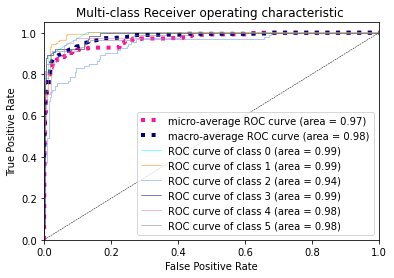

<Figure size 5040x4320 with 0 Axes>

In [0]:
n_classes =  (np.unique(y_train, axis=0).T).size
y_test_bin=label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

 # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])   

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'orchid', 'grey'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.figure(figsize=(70,60))

plt.show()

In [0]:
y_test_pred = text_clf.predict(X_test)
encoder.inverse_transform(y_test_pred)

array(['NUM', 'LOC', 'HUM', 'DESC', 'NUM', 'NUM', 'HUM', 'DESC', 'DESC',
       'DESC', 'LOC', 'DESC', 'NUM', 'HUM', 'NUM', 'NUM', 'LOC', 'HUM',
       'DESC', 'NUM', 'HUM', 'DESC', 'LOC', 'DESC', 'DESC', 'HUM', 'DESC',
       'DESC', 'LOC', 'ENTY', 'NUM', 'LOC', 'DESC', 'NUM', 'NUM', 'NUM',
       'LOC', 'NUM', 'NUM', 'NUM', 'ENTY', 'DESC', 'DESC', 'DESC', 'ENTY',
       'ENTY', 'NUM', 'DESC', 'NUM', 'HUM', 'DESC', 'HUM', 'HUM', 'DESC',
       'DESC', 'DESC', 'NUM', 'LOC', 'LOC', 'DESC', 'LOC', 'HUM', 'LOC',
       'ENTY', 'LOC', 'HUM', 'ENTY', 'DESC', 'NUM', 'LOC', 'NUM', 'NUM',
       'LOC', 'HUM', 'LOC', 'DESC', 'ENTY', 'NUM', 'NUM', 'HUM', 'DESC',
       'NUM', 'HUM', 'NUM', 'NUM', 'DESC', 'DESC', 'HUM', 'DESC', 'LOC',
       'ENTY', 'DESC', 'NUM', 'NUM', 'LOC', 'LOC', 'NUM', 'DESC', 'DESC',
       'HUM', 'DESC', 'HUM', 'DESC', 'HUM', 'DESC', 'DESC', 'NUM', 'LOC',
       'NUM', 'LOC', 'ENTY', 'DESC', 'LOC', 'ENTY', 'LOC', 'HUM', 'NUM',
       'ENTY', 'NUM', 'LOC', 'NUM', 'ENTY', '

# Accuracy Metrics

In [0]:
print(metrics.classification_report(y_test, y_test_pred))
metrics.confusion_matrix(y_test_pred, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.79      0.99      0.88       138
           2       0.82      0.76      0.78        94
           3       0.94      0.89      0.91        65
           4       0.87      0.83      0.85        81
           5       0.99      0.81      0.89       113

    accuracy                           0.86       500
   macro avg       0.90      0.84      0.87       500
weighted avg       0.87      0.86      0.86       500



array([[  7,   0,   0,   0,   0,   0],
       [  0, 174,   0,   0,   0,   0],
       [  0,   0,  87,   0,   0,   0],
       [  0,   0,   0,  62,   0,   0],
       [  0,   0,   0,   0,  77,   0],
       [  0,   0,   0,   0,   0,  93]])

In [0]:
text_clf

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,

In [0]:
# drive.mount('/content/gdrive', force_remount=True)

In [0]:
! ls /content/gdrive/My\ Drive

ls: cannot access '/content/gdrive/My Drive': No such file or directory


In [0]:
# Serialize the label encoder
# This will be required at inference time
encoder_path = '/content/label_encoder.pkl'
with open(encoder_path, 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# MLflow

Serialize and package the model for production

In [0]:
model_path = '/content/model.pkl'
with open(model_path, 'wb') as handle:
    pickle.dump(text_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
mlflow.pyfunc.get_default_conda_env()

{'channels': ['defaults'],
 'dependencies': ['python=3.6.9', {'pip': ['mlflow', 'cloudpickle==1.3.0']}],
 'name': 'mlflow-env'}

In [0]:
artifacts = {
    "model": model_path,
    "label_encoder": encoder_path
}

In [0]:
# This will serve as an MLflow wrapper for the model
class ModelWrapper(mlflow.pyfunc.PythonModel):

    # Load in the model and all required artifacts
    # The context object is provided by the MLflow framework
    # It will contain all of the artifacts specified above
    def load_context(self, context):

        # Initialize the model and load in the state dict
        with open(context.artifacts['model'], 'rb') as handle:
          self.model = pickle.load(handle)
        
        # Load in and deserialize the label encoder object
        with open(context.artifacts["label_encoder"], 'rb') as handle:
            self.label_encoder = pickle.load(handle)

    # Create a predict function for our models
    def predict(self, context, model_input):
        predictions = self.model.predict(model_input)
        pred_labels = self.label_encoder.inverse_transform(predictions)
        return pred_labels

    def explain(self, context, model_input):
        explainer = LimeTextExplainer(class_names=['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'])
        exp = explainer.explain_instance(model_input, self.model.predict_proba, num_features=3, top_labels=6)
        return exp.as_list()

In [0]:
mlflow_pyfunc_model_path = f"/content/gdrive/My Drive/MLOPS/TREC/trec_model_pyfunc6"

# Package the model!
mlflow.pyfunc.save_model(
    path=mlflow_pyfunc_model_path,
    python_model=ModelWrapper(),
    artifacts=artifacts
#  data_path=pyfun_data,
#  code_path=[wrapper_model.__file__],
#  conda_env='/content/conda_env.yaml' 
)

# import wrapper_model ??? /python file

In [0]:
# Load the model in `python_function` format
loaded_model = mlflow.pyfunc.load_model(mlflow_pyfunc_model_path)

# Evaluate the model
test_predictions = loaded_model.predict(['Is my food spicy'])
print(test_predictions)

['DESC']


In [0]:
# Evaluate the model
test_predictions = loaded_model.predict(['who was the inventor of silly putty ?'])
print(test_predictions)



['HUM']


# Explain

In [0]:
import lime
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'])
exp = explainer.explain_instance("Where in the world is Toronto Canada? I am really lost and I can't find it", 
                                 text_clf.predict_proba, num_features=3, top_labels=6)
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [0]:
exp.show_in_notebook

<bound method Explanation.show_in_notebook of <lime.explanation.Explanation object at 0x7f2d853ad128>>

In [0]:
exp.as_list()

[('Where', -0.24509776686960602),
 ('world', -0.10700860121715333),
 ('is', 0.09661349341572638)]

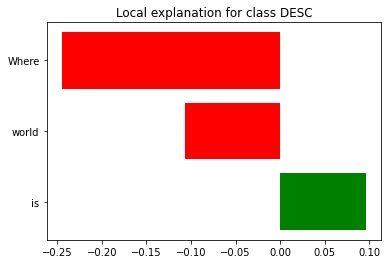

In [0]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [0]:
# import webbrowser
# output_filename = "explanation.html"
# exp.save_to_file(output_filename)
# webbrowser.open(output_filename.as_uri())